In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

import matplotlib.pyplot as plt
from lib.plotting import adjust_plot_1d

In [2]:
bp = '/home/storage/hans/jax_reco_new/examples/check_seed/'

In [3]:
data = np.load(bp+'reco_result_21217_21220_sigma_3.0_clipcharge200_c_multi_gamma_mpe_prob_midpoint2_v_AND_weighted_noise_splineMPEseed.npy')

In [4]:
data.shape

(202092, 26)

In [5]:
SPE_conv = np.load('/home/storage/hans/jax_reco_new/examples/compare_methods/reco_result_21217_21220_sigma_3.0_SPE_cgamma_c_multi_gamma_prob.npy')

In [6]:
SPE_conv.shape

(202092, 20)

In [7]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [8]:
def get_gcd(results, scale=20, result_idx=14):
    reco_zenith, reco_azimuth = results[:, result_idx]/scale, results[:, result_idx+1]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

In [9]:
def get_resolution(results, scale=20, result_idx=14):
    gcd, gcd_smpe, muon_energy = get_gcd(results, scale=scale, result_idx=result_idx)
       
    def get_quantiles(dpsi, energy, e_bins):
        lower, med, upper = [], [], []
        for el, eh in zip(e_bins[:-1], e_bins[1:]):
            #print(el, eh)
            idx = np.logical_and(energy >= el, energy < eh)
            l, m, u = np.percentile(dpsi[idx], [20, 50, 80])
            lower.append(l)
            med.append(m)
            upper.append(u)
        
        return lower, med, upper

    e_nu_range = [2.0, 6.0]
    e_nu_bins = np.linspace(*e_nu_range, 21)
    centers = lambda x: 0.5 * (x[:-1]+x[1:])
    e_nu_centers = centers(e_nu_bins)
    lower, med, upper = get_quantiles(gcd, np.log10(muon_energy), e_nu_bins)
    lower2, med2, upper2 = get_quantiles(gcd_smpe, np.log10(muon_energy), e_nu_bins)

    return (lower, med, upper), (lower2, med2, upper2), e_nu_centers

In [10]:
seed_true, r_smpe, xvals = get_resolution(data, scale=100)
seed_smpe, _, _  = get_resolution(data, scale=100, result_idx=20)
spe, _, _ = get_resolution(SPE_conv)

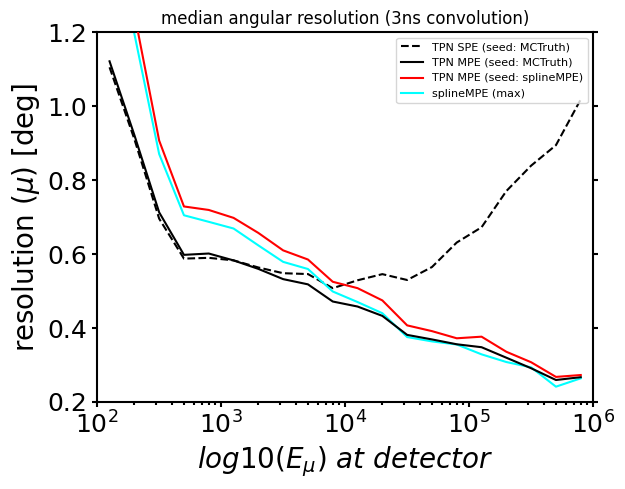

In [11]:
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.2, 1.2]}


ax.plot(10**xvals, spe[1], color='black', label='TPN SPE (seed: MCTruth)', linestyle='dashed')
ax.plot(10**xvals, seed_true[1], color='black', label='TPN MPE (seed: MCTruth)', linestyle='solid', zorder=17)
ax.plot(10**xvals, seed_smpe[1], color='red', label='TPN MPE (seed: splineMPE)', linestyle='solid', zorder=17)
ax.plot(10**xvals, r_smpe[1], color='cyan', label='splineMPE (max)')
#ax.plot(10**xvals, r_smpe[2], color='cyan', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.xscale('log')
plt.title('median angular resolution (3ns convolution)')
ax.set_yticks([0.2*i for i in range(9)][1:-2])
plt.legend(fontsize=8, loc='upper right')
plt.show()

In [12]:
def get_deltalogl(results, idx=19):
    muon_energy = results[:, 0]
    delta_logl = results[:, idx]
    return muon_energy, delta_logl

In [13]:
# -2(log(Ltrue) - (-2logl(Lreco)))
# -2(log(Ltrue) - logl(Lreco))
mu_e, dlogl_true_seed = get_deltalogl(data)
mu_e, dlogl_smpe_seed = get_deltalogl(data, idx=25)

In [14]:
dlogl_true_seed

array([30.45943644, 10.48959239, 26.5405198 , ..., 31.42573954,
       13.45402884, 20.29497848])

In [15]:
dlogl_smpe_seed

array([30.40355794, 10.50990037, 26.21747827, ..., 31.45011785,
       13.29617664, 20.29941924])

In [16]:
dl = dlogl_smpe_seed - dlogl_true_seed

In [17]:
print(np.percentile(dl[np.isfinite(dl)], [10, 16, 50, 84, 90]))

[-0.10275231 -0.01711438  0.00016969  0.01817127  0.1061092 ]


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


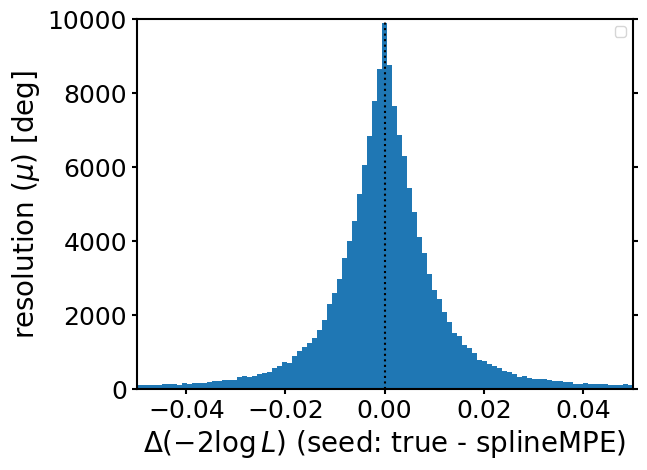

In [18]:
fig, ax = plt.subplots()
ax.hist(dl, bins=np.linspace(-0.05, 0.05, 100))
plot_args = {'xlabel':'$\\Delta(-2\\log L)$ (seed: true - splineMPE)', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[-0.05, 0.05], 
                 'ylim':[0.0, 1.e4]}
plt.axvline(x=0, color='black', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

In [19]:
gcd_seed_true, _, _ = get_gcd(data, scale=100, result_idx=14)
gcd_seed_smpe, _, _ = get_gcd(data, scale=100, result_idx=20)

In [20]:
idx = gcd_seed_smpe > gcd_seed_true + 0.1

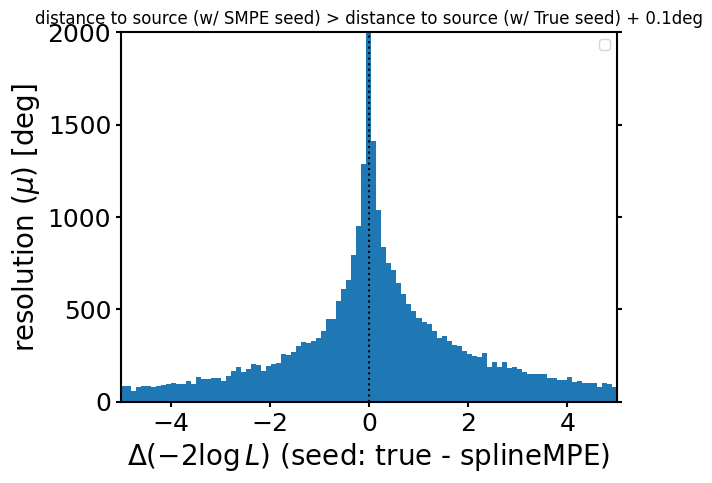

In [21]:
fig, ax = plt.subplots()
ax.hist(dl[idx], bins=np.linspace(-5.0, 5.0, 100))
plot_args = {'xlabel':'$\\Delta(-2\\log L)$ (seed: true - splineMPE)', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[-5.0, 5.0], 
                 'ylim':[0.0, 2000]}
plt.axvline(x=0, color='black', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title("distance to source (w/ SMPE seed) > distance to source (w/ True seed) + 0.1deg")
plt.show()

In [22]:
idx = gcd_seed_true > gcd_seed_smpe + 0.1

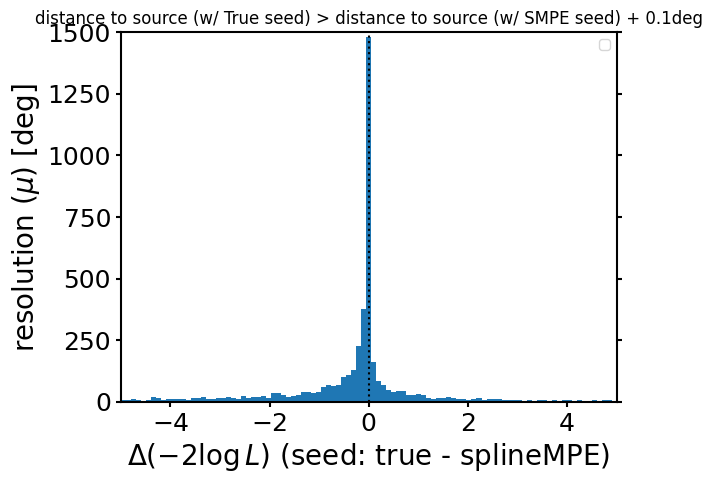

In [23]:
fig, ax = plt.subplots()
ax.hist(dl[idx], bins=np.linspace(-5.0, 5.0, 100))
plot_args = {'xlabel':'$\\Delta(-2\\log L)$ (seed: true - splineMPE)', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[-5.0, 5.0], 
                 'ylim':[0.0, 1500]}
plt.axvline(x=0, color='black', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title("distance to source (w/ True seed) > distance to source (w/ SMPE seed) + 0.1deg")
plt.show()

In [24]:
zenith_true, azimuth_true = data[:, 14], data[:, 15]
zenith_smpe, azimuth_smpe = data[:, 20], data[:, 21]

In [25]:
dpsi = GreatCircleDistance(azimuth_true, zenith_true, azimuth_smpe, zenith_smpe)

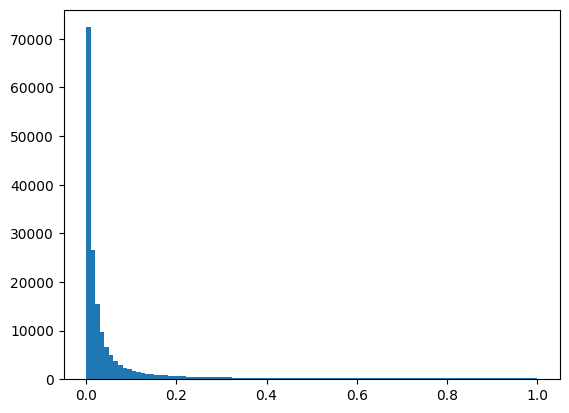

In [28]:
fig, ax = plt.subplots()
plt.hist(dpsi, bins=np.linspace(0.0, 1.0, 100))
plt.show()